In [216]:
import numpy as np
from numpy import *
import scipy.io
import struct

import csv
import numpy
import ipyvolume as ipv
from scipy import interpolate
#from scipy import special
#import matplotlib
#import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
#from matplotlib import cm
#from matplotlib.ticker import LinearLocator, FormatStrFormatter


In [217]:
#set model constants
ep0=8.854188e-12
c=3.0e8

In [218]:
#set model parameters

def setmodelparams():
    pardict={}
    pardict["nx"]=20
    pardict["ny"]=20

    pardict["xmax"]=50.0
    pardict["xmin"]=-50.0
    pardict["ymax"]=50.0
    pardict["ymin"]=-50.0
    pardict["dt"]=0.314159

    pardict["delx"]=(pardict["xmax"]-pardict["xmin"])/pardict["nx"]
    pardict["dely"]=(pardict["ymax"]-pardict["ymin"])/pardict["ny"]
    pardict["nc"]=1 #number of charges
    return pardict

In [219]:
#function to update the electric field and the potential
def updatefields(t,pars,cdat,opotential,oex,oey):
    #extract modelpars from  modelpars
    nx=pars["nx"]
    ny=pars["ny"]
    
    xmax=pars["xmax"]
    xmin=pars["xmin"]
    ymax=pars["ymax"]
    ymin=pars["ymin"]
    
    delx=pars["delx"]
    dely=pars["dely"]
    
    delt=pars["dt"]   #0.1

    #extract chargedat from chargedat
    xp=cdat["xp"]
    yp=cdat["yp"]
    vmag=cdat["vmag"]
    vxp=cdat["vxp"]
    vyp=cdat["vyp"]
    omeg=cdat["omeg"]
    qp=cdat["q"]

    
    for i in range(0,nx):
        for j in range(0,ny):
            #intiailise potential and field because these are computed for each charge
            fpot=0.0
            #ex=0
            #ey=0
            for ic in range(0,nc):
                #compute field position
                x=xmin+delx*i
                y=ymin+dely*j
                #calculate change in charge position
                dx=delt*vmag[ic]*vxp[ic]*np.sin(omeg[ic]*t)
                dy=delt*vmag[ic]*vyp[ic]*np.sin(omeg[ic]*t)
                xp[ic]=xp[ic]+dx
                yp[ic]=yp[ic]+dy
                r12x=x-xp[ic]
                r12y=y-yp[ic]
                r12mag=np.sqrt(r12x*r12x+r12y*r12y)
                # compute component of velocity along field direction i.e. we use the vector dot product
                vrdash=vmag[ic]*(r12x*vxp[ic]+r12y*vyp[ic])/r12mag
                # compute potential
                fpot=fpot+((qp[ic]/r12mag)*(1/(1-vrdash)))
            potential[i,j]=fpot
    
    #compute the fields
    for i in range(0,nx-1):
        for j in range(0,ny-1):        
            #compute gradient (and field using central difference) if boundary assume 0 (charges always in middle of our large grid)
            #
            if i == 0:
                ex[i, j] = (potential[i+1, j]) / delx
            elif i==nx-1:
                ex[i,j]=(-potential[i-1,j])/delx
            else:
                ex[i,j]=(potential[i+1,j]-potential[i-1,j])/delx
                
            if j == 0:
                ey[i,j]=(potential[i,j+1])/dely 
            elif j  == ny-1:   
                ey[i,j]=(-potential[i,j-1])/dely
            else:
                ey[i,j]=(potential[i,j+1]-potential[i,j-1])/dely


    return potential,ex,ey

In [220]:
#modelparams

pars=setmodelparams()
nx=pars["nx"]
ny=pars["ny"]

xmax=pars["xmax"]
xmin=pars["xmin"]
ymax=pars["ymax"]
ymin=pars["ymin"]

delx=pars["delx"]
dely=pars["dely"]

nc=pars["nc"]

delt=pars["dt"]   #0.1

In [221]:
#charge positions
xp=np.zeros(nc)
yp=np.zeros(nc)
vxp=np.zeros(nc)
vyp=np.zeros(nc)
vmag=np.zeros(nc)
omeg=np.zeros(nc)
qp=np.zeros(nc)

#create fields
potential = np.zeros( (nx,ny) ); #scalar potential
ex = np.zeros( (nx,ny) ); # electric field x
ey = np.zeros(  (nx,ny)  ); #electric field y 

In [234]:
#set the charge positions
xp[0]=-3*delx+delx/2   #at cell centre not the grid cell
yp[0]=-3*dely+dely/2

vmag[0]=0.02  #this is in units of c
vyp[0]=np.sin(np.pi/4)
vxp[0]=np.cos(np.pi/4)

omeg[0]=0.25
qp[0]=1.0  #this is the charge divided by 4pi epsilon0



In [235]:
cdat={}
cdat["xp"]=xp
cdat["yp"]=yp
cdat["vmag"]=vmag
cdat["vxp"]=vxp
cdat["vyp"]=vyp
cdat["omeg"]=omeg
cdat["q"]=qp

print(vxp,vyp)

[0.70710678] [0.70710678]


In [236]:
t=0.1
pars=setmodelparams()

cdat["xp"]=xp
cdat["yp"]=yp
cdat["vmag"]=vmag
cdat["vxp"]=vxp
cdat["vyp"]=vyp
cdat["omeg"]=omeg
cdat["q"]=qp

potential,ex,ey=updatefields(t,pars,cdat,potential,ex,ey)

In [237]:
print(potential)

[[0.0184864  0.01975744 0.02108708 0.02243093 0.02371864 0.02485309
  0.02572018 0.02621239 0.02626107 0.0258613  0.02507345 0.02400045
  0.02275582 0.02143876 0.02012295 0.01885616 0.01766532 0.01656263
  0.01555092 0.01462753]
 [0.01975625 0.02132892 0.02302786 0.0248077  0.02657948 0.02819985
  0.02947807 0.03021658 0.03028162 0.02966452 0.02848525 0.02693549
  0.02520738 0.02344956 0.02175708 0.02018058 0.01874054 0.01743946
  0.0162704  0.01522206]
 [0.0210844  0.02302625 0.02520442 0.02758941 0.03008473 0.03248841
  0.03447572 0.03565875 0.03574999 0.03473274 0.03287017 0.03054427
  0.02808722 0.02571286 0.02352819 0.02157027 0.01983839 0.0183146
  0.01697498 0.01579516]
 [0.02242648 0.02480401 0.0275871  0.03080102 0.03438742 0.03810362
  0.0414062  0.04347718 0.04361424 0.04178095 0.03863423 0.03499351
  0.03142674 0.02820076 0.02539026 0.02297934 0.02091949 0.01915633
  0.0176399  0.01632768]
 [0.0237122  0.0265733  0.03007935 0.03438384 0.03959247 0.04557123
  0.05153059 0.05

-50.0 50.0 5.0 (21,) (20, 20)


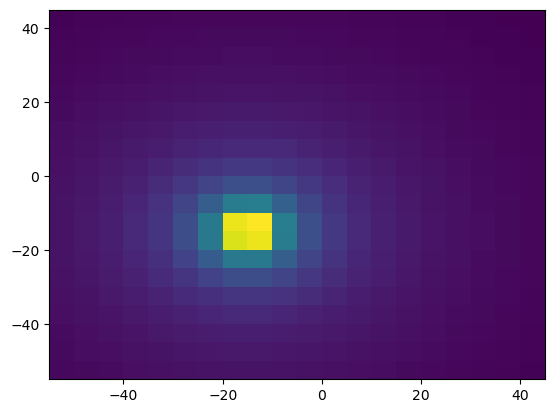

In [238]:
fig, ax = plt.subplots()
Z=potential
x=np.arange(start=xmin-delx, stop=xmax, step=delx)
y=np.arange(start=ymin-dely, stop=ymax, step=dely)

print(xmin,xmax,delx,np.shape(x),np.shape(Z))
s=ax.pcolormesh(x, y, Z, shading='flat', vmin=Z.min(), vmax=Z.max())

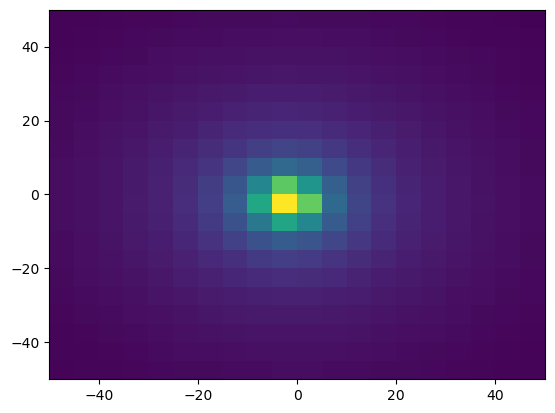

In [239]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

dt=pars["dt"]
fig, ax = plt.subplots()
Z=potential
x=np.arange(start=xmin, stop=xmax+delx, step=delx)
y=np.arange(start=ymin, stop=ymax+dely, step=dely)

#global s
s =ax.pcolormesh(x, y, Z, shading='flat', vmin=Z.min(), vmax=Z.max())

#def init():  # only required for blitting to give a clean slate.
#    global s
#    potential,ex,ey=updatefields(0,pars,cdat,potential,ex,ey)   
#    s.set_array(potential.ravel())  # use set_array for pcolormesh!
#    #s.set_zdata(potential)
#    return s,

#state = {"potential": potential, "ex": ex, "ey": ey}




def animate(i, s):
    global potential, ex, ey
    potential, ex, ey = updatefields(i * dt, pars, cdat, potential, ex, ey)
    s.set_array(potential.ravel())
    return s,


#ani = animation.FuncAnimation(fig, animate, fargs=(s, state), interval=2, blit=True, save_count=50)
ani = animation.FuncAnimation(fig, animate, fargs=(s,), interval=2, blit=True, save_count=150)







HTML(ani.to_jshtml())


In [99]:
# f(u, v) -> (u, v, u*v**2)

Z=potential
x=np.arange(start=xmin, stop=xmax+delx, step=delx)
y=np.arange(start=ymin, stop=ymax+dely, step=dely)
#a = np.arange(-5, 5)
U, V = np.meshgrid(x, y)
X = U
Y = V
#Z = X*Y**2

ipv.figure()
ipv.plot_surface(X, Z, Y, color="orange")
ipv.plot_wireframe(X, Z, Y, color="red")
ipv.show()

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…